#CUSTOMER RETURNS PREDICTION PROJECT



Aim: Predicting customer returns based on historical transaction data

Step 1 - Loading and Exploring the Dataset

In [ ]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

#Loading the Dataset
df = pd.read_excel('/content/online_retail_II.xlsx', sheet_name='Year 2010-2011')

#Initial Exploration
print("Shape:", df.shape)
print(df.head())
print(df.info())

Shape: (541910, 8)
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----

Step 2 - Cleaning the Data and Identifying Returns

In [ ]:
#Data Cleaning
#Removing rows where CustomerID is missing
df = df.dropna(subset=['Customer ID'])

#Ensuring the 'InvoiceDate' column is in a datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

#Identify Returns - Checking if the numbers in the column 'Invoice' start with the letter 'C' as it indicates a return.
#A new column 'IsReturn' is created, where 1 means it's a return and 0 means it's not.
df['IsReturn'] = df['Invoice'].astype(str).str.startswith('C').astype(int)

Step 3 - Feature Engineering

In [ ]:
#Feature Engineering
#Calculating the total price for each item in an invoice by multiplying the quantity and the price
df['TotalPrice'] = df['Quantity'] * df['Price']

#Extracting the year, month, day, and hour from the 'InvoiceDate' column
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

# Aggregating the data at the customer level
# Instead of having one row per item in an invoice, we'll have one row per customer as we calculate the following for each customer:
customer_df = df.groupby('Customer ID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'Invoice': 'nunique',
    'IsReturn': 'sum',
    'Country': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()

#Creating our target variable, 'Returned'
customer_df['Returned'] = (customer_df['IsReturn'] > 0).astype(int)

#Dropping the 'IsReturn' column since we have created the 'Returned' column
customer_df = customer_df.drop(columns=['IsReturn'])


Step 4 - Encoding Categorical Variable

In [ ]:
#Encode Categorical Variable (Country) - Converting the 'Country' column values into numerical values
le = LabelEncoder()
customer_df['Country'] = le.fit_transform(customer_df['Country'])

Step 5 - Spliting Features and Target

In [ ]:
#Split Features and Target

#Creating 'X' for features that the model will use to predict returns, dropping columns 'Returned' and 'Customer ID'
X = customer_df.drop(columns=['Returned', 'Customer ID'])

#Creating 'y' for the target, we want our model to predict this
y = customer_df['Returned']

Step 6 - Train-Test Split

In [ ]:
#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Step 7 - Feature Scaling

In [ ]:
#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Step 8 - Training with Random Forest

In [ ]:
# STEP 8: Random Forest

rf = RandomForestClassifier(
    n_estimators=100, # Specifying the number of trees
    max_depth=10, # Specifying maximum depth of each tree
    min_samples_split=10, # The minimum number of samples required to split an internal node
    min_samples_leaf=5, # The minimum number of samples required to be at a leaf node
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_prob = rf.predict_proba(X_test_scaled)[:, 1]   #Getting the probabilities for each class on the scaled testing features

#Evaluating Random Forest
print("\n RANDOM FOREST RESULTS:")
print(classification_report(y_test, rf_pred))
print("Accuracy:", accuracy_score(y_test, rf_pred))



 RANDOM FOREST RESULTS:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       557
           1       0.67      0.84      0.74       318

    accuracy                           0.79       875
   macro avg       0.78      0.80      0.78       875
weighted avg       0.81      0.79      0.79       875

Accuracy: 0.7874285714285715


Step 9 - Training with Logistic Regression

In [ ]:
# STEP 9: Logistic Regression

lr = LogisticRegression(
    solver='lbfgs', #Specifying the algorithm to use for optimization
    max_iter=1000, #Setting the maximum number of iterations for the solver to converge
    class_weight='balanced',
    random_state=42
)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_prob = lr.predict_proba(X_test_scaled)[:, 1]

#Evaluating Logistic Regression
print("\n LOGISTIC REGRESSION RESULTS:")
print(classification_report(y_test, lr_pred))
print("Accuracy:", accuracy_score(y_test, lr_pred))


 LOGISTIC REGRESSION RESULTS:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       557
           1       0.77      0.70      0.73       318

    accuracy                           0.81       875
   macro avg       0.80      0.79      0.80       875
weighted avg       0.81      0.81      0.81       875

Accuracy: 0.8148571428571428


Step 10 - Training with XGBoost

In [ ]:
# STEP 10: XGBoost

xgb = XGBClassifier(
    n_estimators=200, # Specifying number of boosting rounds (trees)
    learning_rate=0.05, # Controlling the step size shrinkage during boosting
    max_depth=6, #Specifying the maximum depth of the individual trees
    subsample=0.8, # The fraction of samples to be used for fitting the individual base learners.
    colsample_bytree=0.8, # The fraction of features to be used for fitting the individual base learners.
    random_state=42,
    scale_pos_weight=1, #Controlling the balance of positive and negative weights
    eval_metric='logloss' #Evaluation metric used during training, a common metric for binary classification.
)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
xgb_prob = xgb.predict_proba(X_test_scaled)[:, 1]

#Evaluating XGBoost
print("\n XGBOOST RESULTS:")
print(classification_report(y_test, xgb_pred))
print("Accuracy:", accuracy_score(y_test, xgb_pred))


 XGBOOST RESULTS:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       557
           1       0.73      0.76      0.74       318

    accuracy                           0.81       875
   macro avg       0.79      0.80      0.79       875
weighted avg       0.81      0.81      0.81       875

Accuracy: 0.808


Step 11 - Confusion Matrices

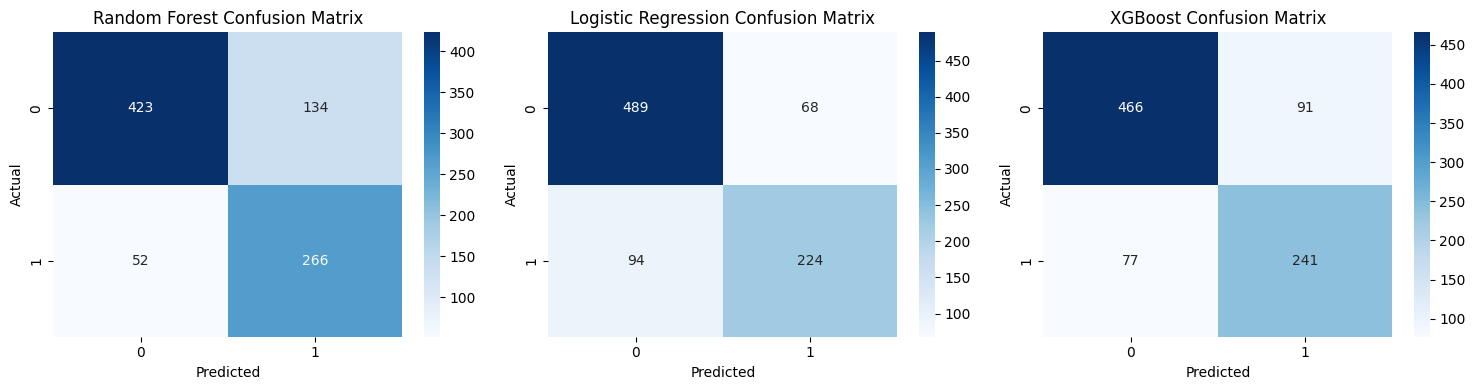

In [ ]:
# STEP 11: Confusion Matrices
#Displaying the confusion matrices for the three models side-by-side

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = {
    'Random Forest': (y_test, rf_pred),
    'Logistic Regression': (y_test, lr_pred),
    'XGBoost': (y_test, xgb_pred)
}

for i, (name, (yt, yp)) in enumerate(models.items()):
    cm = confusion_matrix(yt, yp)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


Step 12 - ROC-AUC Curves

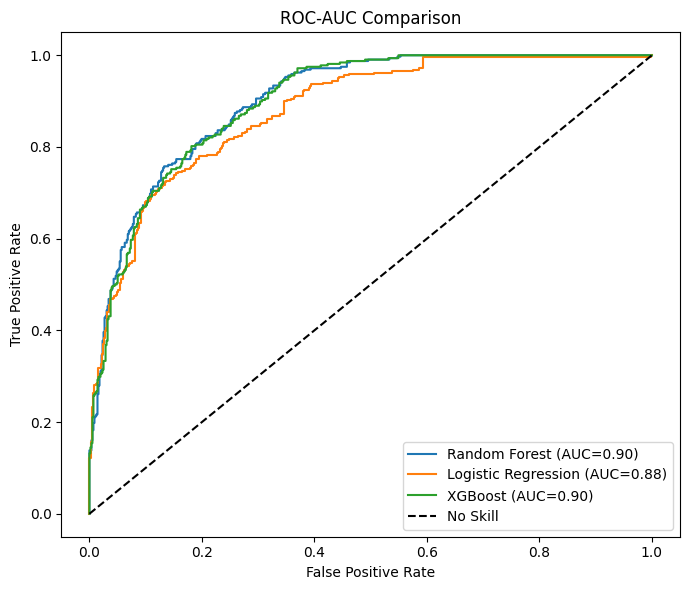

In [ ]:
# STEP 12: ROC-AUC Curves
#Comparing ROC-AUC Curve score of the 3 models - False Positive Rate vs True Positive Rate

plt.figure(figsize=(7, 6))

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, rf_prob):.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, lr_prob):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, xgb_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.title('ROC-AUC Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()


 Step 13 - Model Comparison Summary


 Model Comparison Summary:
                 Model  Accuracy       AUC
0        Random Forest  0.787429  0.902016
1  Logistic Regression  0.814857  0.880334
2              XGBoost  0.808000  0.899046


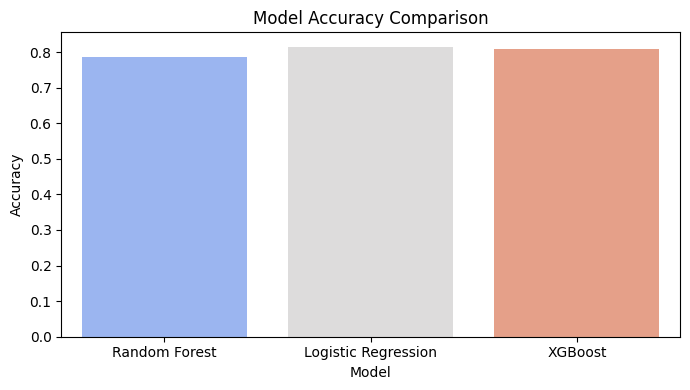

In [ ]:
# STEP 13: Model Comparison Summary
#Comapring the performance metrics of the 3 models

results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, xgb_pred)
    ],
    'AUC': [
        roc_auc_score(y_test, rf_prob),
        roc_auc_score(y_test, lr_prob),
        roc_auc_score(y_test, xgb_prob)
    ]
})
print("\n Model Comparison Summary:")
print(results)

plt.figure(figsize=(7,4))
sns.barplot(x='Model', y='Accuracy', data=results, palette='coolwarm')
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.show()


Step 14 - Feature Importance (Random Forest & XGBoost)

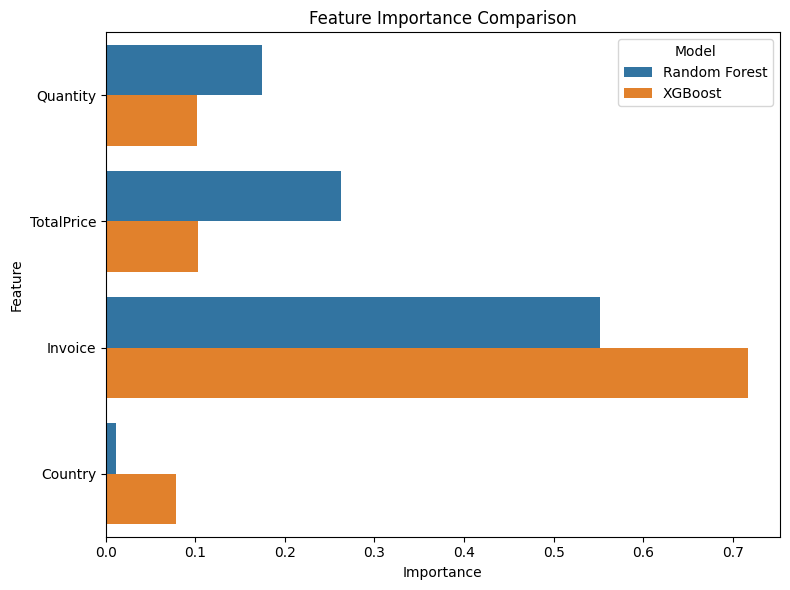


Feature Importances:
       Feature  Importance          Model
0    Quantity    0.174173  Random Forest
1  TotalPrice    0.263098  Random Forest
2     Invoice    0.551754  Random Forest
3     Country    0.010976  Random Forest
0    Quantity    0.101667        XGBoost
1  TotalPrice    0.102480        XGBoost
2     Invoice    0.716944        XGBoost
3     Country    0.078909        XGBoost


In [ ]:
# STEP 14: Feature Importance (Random Forest & XGBoost)

# Understanding which features the models considered most important when making predictions

rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_,
    'Model': 'Random Forest'
})

xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_,
    'Model': 'XGBoost'
})

importances = pd.concat([rf_importance, xgb_importance])

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', hue='Model', data=importances)
plt.title("Feature Importance Comparison")
plt.tight_layout()
plt.show()

print("\nFeature Importances:\n", importances)

Conclusion and Interpretation

Based on the results from the model training and analysis:

1. Which model performed best?

Looking at the Model Comparison Summary (Step 13), the Logistic Regression model has the highest accuracy (0.815), while the Random Forest model has the highest AUC score (0.902). The "best" model depends on what metric is most important for the business problem. If correctly identifying as many actual returns as possible is critical (high recall for the positive class), Random Forest's higher AUC might be preferable, as AUC is a good measure of a model's ability to distinguish between classes.


2. What do the confusion matrices tell you?

The confusion matrices (Step 11) provide a detailed look at the model's predictions:

Random Forest: Has a good balance of True Positives (correctly predicting returns) and True Negatives (correctly predicting non-returns). Its recall for the positive class (returns) is quite high (84%, from the classification report in Step 8), meaning it identifies a large portion of actual returns. However, its precision for the positive class is lower (67%), indicating it also incorrectly flags some non-returns as returns (False Positives).

Logistic Regression: Has a higher precision for the positive class (77%, from Step 9), meaning when it predicts a return, it's more likely to be correct compared to Random Forest. However, its recall for the positive class is lower (70%), meaning it misses more actual returns than Random Forest. It has a higher number of True Negatives.

XGBoost: Shows a performance somewhere between Random Forest and Logistic Regression in terms of the trade-off between precision and recall for the positive class (precision 73%, recall 76%, from Step 10).

3. Which features were most important?

According to both the Random Forest and XGBoost feature importance plots (Step 14), the number of 'Invoice' (unique invoices per customer) is by far the most important feature for predicting returns. 'TotalPrice' and 'Quantity' are also important, but significantly less so than 'Invoice'. 'Country' has the least importance.

4. What insights can you gain?

The high importance of the 'Invoice' feature suggests that the frequency or number of transactions a customer has is a strong indicator of whether they will make a return. Customers with a higher number of invoices might be more active shoppers, and thus have a higher chance of having a return. The importance of 'TotalPrice' and 'Quantity' indicates that the volume and value of purchases also play a role. The low importance of 'Country' suggests that geographical location, after accounting for other factors, is not a primary driver of returns in this dataset.

5. What could be potential next steps?

Hyperparameter Tuning: The current models use default or initial parameters. Tuning the hyperparameters of the chosen model (perhaps Random Forest or XGBoost, given their higher AUC) could potentially improve performance.

Explore other models: Consider trying other classification algorithms like Support Vector Machines (SVMs) or Naive Bayes.

Feature Engineering: Explore creating more features. For example, you could look at the time between invoices, the variety of items purchased, or the average value per invoice.

Collect More Data: A larger dataset might help the models learn more complex patterns.

Deeper Feature Analysis: Investigate the relationship between the number of invoices and returns more deeply. Are there specific thresholds or patterns in invoice frequency that strongly correlate with returns?

Address Class Imbalance: While class_weight='balanced' was used in some models, further techniques for handling class imbalance (like oversampling the minority class or undersampling the majority class) could be explored, especially if recall for the positive class is a primary goal.